# Transfer learning - Scaling-up

A common practice in ML is to train a model in a small amount of data before scaling it up to larger amounts

<img src='https://camo.githubusercontent.com/3a44366f7797035e9e0dae2900708e0c146718f373136a0ba3a8251a4e63f6ec/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d6d6c2d73657269616c2d6578706572696d656e746174696f6e2e706e67'>

Past few notebooks focused on 10 classes, here all 101 classes will be explored

In [1]:
!nvidia-smi

Sun Oct  2 03:49:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import helper functions
!wget https://raw.githubusercontent.com/Ammar-Raneez/TF_Learning_ZTM/main/helper_functions.py

--2022-10-02 03:51:27--  https://raw.githubusercontent.com/Ammar-Raneez/TF_Learning_ZTM/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9822 (9.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.59K  --.-KB/s    in 0s      

2022-10-02 03:51:27 (90.7 MB/s) - ‘helper_functions.py’ saved [9822/9822]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Phase 01 - 10% of data, Feature Extraction

### Data Exploration

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-10-02 04:10:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   191MB/s    in 6.9s    

2022-10-02 04:10:40 (224 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [9]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 7

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [8]:
# Create data loaders
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    # Reproducible test data - so that repeated evaluation & visualizations can be done
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Create model

Start with feature extraction transfer-learning and then scale up to fine-tuning.

In [11]:
# Create model checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

Create data augmentation layer since `image_dataset_from_directory` cannot augment. Additionally, augmentating occurs only during model creation and utilizes the GPU

In [13]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1./255) # Not required for EfficientNet
], name='data_augmentation')

<img src='https://camo.githubusercontent.com/823a5d4af3671b64d4854463c09262fd02f801ad34be28dc4890c42ef74b6288/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d656666696369656e746e657462302d666561747572652d657874726163746f722d776974682d64656e73652d6c617965722d6f6e2d746f702e706e67'/>

In [16]:
# Create model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)

# Pool outputs of base model to a shape that can be used by the output layer
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation='linear', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [21]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_1 = model.fit(
    train_data_10_percent,
    epochs=5,
    validation_data = test_data,
    validation_steps = .25 * len(test_data),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 97s 341ms/step - loss: 3.4803 - accuracy: 0.2512 - val_loss: 2.7320 - val_accuracy: 0.3529
Epoch 2/5
237/237 [==============================] - 65s 271ms/step - loss: 2.3528 - accuracy: 0.4634 - val_loss: 2.3214 - val_accuracy: 0.4151
Epoch 3/5
237/237 [==============================] - 55s 231ms/step - loss: 1.9883 - accuracy: 0.5237 - val_loss: 2.1277 - val_accuracy: 0.4545
Epoch 4/5
237/237 [==============================] - 58s 244ms/step - loss: 1.7721 - accuracy: 0.5650 - val_loss: 2.0527 - val_accuracy: 0.4642
Epoch 5/5
237/237 [==============================] - 53s 224ms/step - loss: 1.5996 - accuracy: 0.6104 - val_loss: 2.0013 - val_accuracy: 0.4727


In [25]:
feature_extract_results = model.evaluate(test_data)
feature_extract_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7290 - accuracy: 0.5480


[1.7289990186691284, 0.5479999780654907]

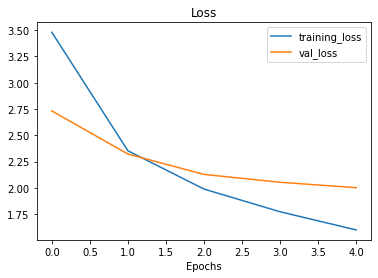

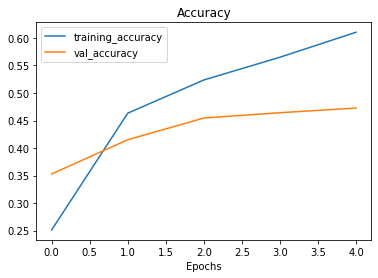

In [27]:
plot_loss_curves(history_1)

Model seems to be overfitting

## Phase 02 - 10% of data, Fine-tuning

thanks to the `ModelCheckpoint` callback, the saved weights of the well-performing model is saved, so it can be reverted if fine-tuning doesn't add any benefits



<img src='https://camo.githubusercontent.com/62c181e8f23fb727b46bda5959d956343250717a6c09505aa9975ca02ff11e4c/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d6c6f776572696e672d7468652d6c6561726e696e672d726174652e706e67'/>

As a rule-of-thumb for fine-tuning, the `learning_rate` must be  10x lower to ensure the updates to the previous trained weights aren't too large.

In [28]:
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [30]:
# Recompile model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [31]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling True
output_layer True


In [32]:
# Check which layers are trainable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [33]:
history_1.epoch

[0, 1, 2, 3, 4]

In [34]:
# Fit model starting from epoch feature_extraction ended off
history_2 = model.fit(
    train_data_10_percent,
    validation_data=test_data,
    epochs=10,
    validation_steps = int(.15 * len(test_data)),
    initial_epoch=history_1.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 54s 200ms/step - loss: 1.3741 - accuracy: 0.6422 - val_loss: 1.9605 - val_accuracy: 0.4883
Epoch 6/10
237/237 [==============================] - 42s 177ms/step - loss: 1.2526 - accuracy: 0.6686 - val_loss: 1.9568 - val_accuracy: 0.4878
Epoch 7/10
237/237 [==============================] - 41s 172ms/step - loss: 1.1559 - accuracy: 0.6920 - val_loss: 1.9647 - val_accuracy: 0.4952
Epoch 8/10
237/237 [==============================] - 42s 174ms/step - loss: 1.0724 - accuracy: 0.7162 - val_loss: 1.9308 - val_accuracy: 0.5032
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0245 - accuracy: 0.7270 - val_loss: 1.9562 - val_accuracy: 0.4918
Epoch 10/10
237/237 [==============================] - 39s 162ms/step - loss: 0.9618 - accuracy: 0.7434 - val_loss: 1.9669 - val_accuracy: 0.4958


In [35]:
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6187 - accuracy: 0.5744


[1.6186842918395996, 0.5743762254714966]

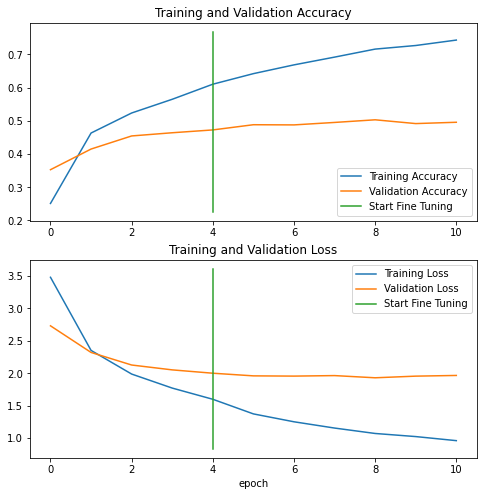

In [36]:
# Compare histories
compare_historys(
    original_history=history_1,
    new_history=history_2,
    initial_epochs=5
)

Model is overfitting (validation seems to have plateaued.

**Side-note** Its common for fine-tuned models to overfit when the pre-trained model has been trained on similar data to the custom data. In this case, the Food101 data and `ImageNet` is similar.

If feature extraction already works well, the improvements from fine-tuning may not be as great as if the dataset was significantly different from the data the base model was pre-trained on.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Save model
model.save('drive/My Drive/101_food_class_10_percent_model')

In [39]:
# Load model
loaded_model = tf.keras.models.load_model('drive/My Drive/101_food_class_10_percent_model')

In [40]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 60s 74ms/step - loss: 1.6187 - accuracy: 0.5744


[1.6186842918395996, 0.5743762254714966]

### Evaluate Model

In [42]:
# Make predictions with model
pred_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 61s 75ms/step


In [43]:
# (No. of test data, No. of classes)
pred_probs.shape

(25250, 101)

In [47]:
# Convert prediction probs to softmax
pred_probs = tf.nn.softmax(pred_probs)
pred_probs[0]

<tf.Tensor: shape=(101,), dtype=float32, numpy=
array([0.00995421, 0.00989992, 0.00990625, 0.0098999 , 0.0098999 ,
       0.0098999 , 0.00989991, 0.0098999 , 0.00990164, 0.00989995,
       0.0098999 , 0.0098999 , 0.00990012, 0.0098999 , 0.0099016 ,
       0.00990003, 0.0098999 , 0.00990005, 0.00990017, 0.0098999 ,
       0.00989994, 0.0098999 , 0.00989991, 0.00989992, 0.00989995,
       0.00989992, 0.00989993, 0.0098999 , 0.00990472, 0.00990012,
       0.0098999 , 0.0099001 , 0.00990001, 0.0098999 , 0.00990072,
       0.0098999 , 0.00989993, 0.00989999, 0.00990132, 0.0098999 ,
       0.00989997, 0.00989995, 0.00989994, 0.0098999 , 0.0098999 ,
       0.0098999 , 0.00990009, 0.00989991, 0.0098999 , 0.00990228,
       0.00989994, 0.0098999 , 0.00991765, 0.00990074, 0.0098999 ,
       0.00990257, 0.00990128, 0.00990006, 0.00990014, 0.0098999 ,
       0.0098999 , 0.00989993, 0.00990277, 0.00989991, 0.0098999 ,
       0.00989994, 0.0098999 , 0.00990023, 0.00990004, 0.00990039,
       0.00989

Index of max value is the class the model has predicted it likely could be, and vice-versa

In [52]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

AttributeError: ignored

In [53]:
# Get the class predictons of each label
pred_classes = tf.argmax(pred_probs, axis=1)
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 0,  0,  0,  8,  0, 78, 29, 46,  9,  0])>

To get the test dataset labels the `test_data` of type italicized text `tf.data.Dataset` can be unravelled

**Note**: This unravelling is why `shuffle=False` is done. Otherwise, whenever the test dataset is loaded (when making predictions), it would be shuffled every time, meaning the predictions and the `test_data` would be in different orders.

In [54]:
y_labels = []

# Unbatch test data & append get index which has the largest value (labels are one-hot)
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
# Make sure labels & preds are in the right order
from sklearn.metrics import accuracy_score
sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc, loaded_model_results[1]

(0.5743762376237623, 0.5743762254714966)

Similar accuracies - same order

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [73]:
# Create confusion matrix
cf = confusion_matrix(y_labels, pred_classes)
cf_m = ConfusionMatrixDisplay(cf, display_labels=test_data.class_names)
fig, ax = plt.subplots(figsize=(100, 100), dpi=100)
cf_m.plot(ax=ax, xticks_rotation='vertical');

Model seems to confuse with classes that look similar to each other, although it does perform well. (Diagonal column is has most classes)

In [74]:
# Create classification report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.19      0.23       250
           1       0.58      0.68      0.63       250
           2       0.72      0.56      0.63       250
           3       0.86      0.44      0.58       250
           4       0.50      0.40      0.45       250
           5       0.46      0.28      0.35       250
           6       0.79      0.70      0.74       250
           7       0.88      0.66      0.76       250
           8       0.23      0.54      0.32       250
           9       0.41      0.58      0.48       250
          10       0.64      0.36      0.46       250
          11       0.85      0.47      0.60       250
          12       0.65      0.61      0.63       250
          13       0.60      0.50      0.55       250
          14       0.57      0.48      0.52       250
          15       0.46      0.22      0.30       250
          16       0.72      0.38      0.50       250
          17       0.27    

**Precision (PPV)**: Proportion of TPs over No. of samples. Higher precision leads to lower FPs.

**Recall (Sensitivity)**: Proportion of TPs over No. of all positives (TPs & FNs). Higher recall leads to lower FNs.

**F1 Score**: Combination of both

In [75]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2962962962962963,
  'recall': 0.192,
  'f1-score': 0.23300970873786406,
  'support': 250},
 '1': {'precision': 0.5816326530612245,
  'recall': 0.684,
  'f1-score': 0.6286764705882354,
  'support': 250},
 '2': {'precision': 0.7216494845360825,
  'recall': 0.56,
  'f1-score': 0.6306306306306305,
  'support': 250},
 '3': {'precision': 0.859375,
  'recall': 0.44,
  'f1-score': 0.582010582010582,
  'support': 250},
 '4': {'precision': 0.5024875621890548,
  'recall': 0.404,
  'f1-score': 0.4478935698447894,
  'support': 250},
 '5': {'precision': 0.461038961038961,
  'recall': 0.284,
  'f1-score': 0.3514851485148515,
  'support': 250},
 '6': {'precision': 0.7882882882882883,
  'recall': 0.7,
  'f1-score': 0.7415254237288137,
  'support': 250},
 '7': {'precision': 0.8823529411764706,
  'recall': 0.66,
  'f1-score': 0.7551487414187643,
  'support': 250},
 '8': {'precision': 0.23103448275862068,
  'recall': 0.536,
  'f1-score': 0.3228915662650602,
  'support': 250},
 '9': {

In [76]:
# Extract only f1-score of all classes - its a combination therefore is enough to evaluate
f1_scores = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    # End at accuracy key (accuracy key is after index)
    break
  
  # Store f1-score for each class_name
  f1_scores[test_data.class_names[int(k)]] = v['f1-score']

f1_scores

{'apple_pie': 0.23300970873786406,
 'baby_back_ribs': 0.6286764705882354,
 'baklava': 0.6306306306306305,
 'beef_carpaccio': 0.582010582010582,
 'beef_tartare': 0.4478935698447894,
 'beet_salad': 0.3514851485148515,
 'beignets': 0.7415254237288137,
 'bibimbap': 0.7551487414187643,
 'bread_pudding': 0.3228915662650602,
 'breakfast_burrito': 0.48026315789473684,
 'bruschetta': 0.4631043256997456,
 'caesar_salad': 0.6046511627906977,
 'cannoli': 0.6322314049586777,
 'caprese_salad': 0.5470459518599562,
 'carrot_cake': 0.5207877461706784,
 'ceviche': 0.3010752688172043,
 'cheese_plate': 0.5013054830287207,
 'cheesecake': 0.37027379400260757,
 'chicken_curry': 0.4886877828054299,
 'chicken_quesadilla': 0.564334085778781,
 'chicken_wings': 0.7099391480730223,
 'chocolate_cake': 0.5177304964539007,
 'chocolate_mousse': 0.3123543123543124,
 'churros': 0.7089108910891089,
 'clam_chowder': 0.6824034334763949,
 'club_sandwich': 0.679245283018868,
 'crab_cakes': 0.3521739130434783,
 'creme_brulee'

In [82]:
# Order f1-scores for visualization
import pandas as pd
f1_scores_df = pd.DataFrame({
    'class_name': list(f1_scores.keys()),
    'f1-score': list(f1_scores.values())
}).sort_values('f1-score', ascending=False)

f1_scores_df

,class_name,f1-score
33,edamame,0.951456
75,pho,0.858896
63,macarons,0.832599
86,sashimi,0.825651
45,frozen_yogurt,0.822034
...,...,...
22,chocolate_mousse,0.312354
56,huevos_rancheros,0.309896
15,ceviche,0.301075
39,foie_gras,0.264339


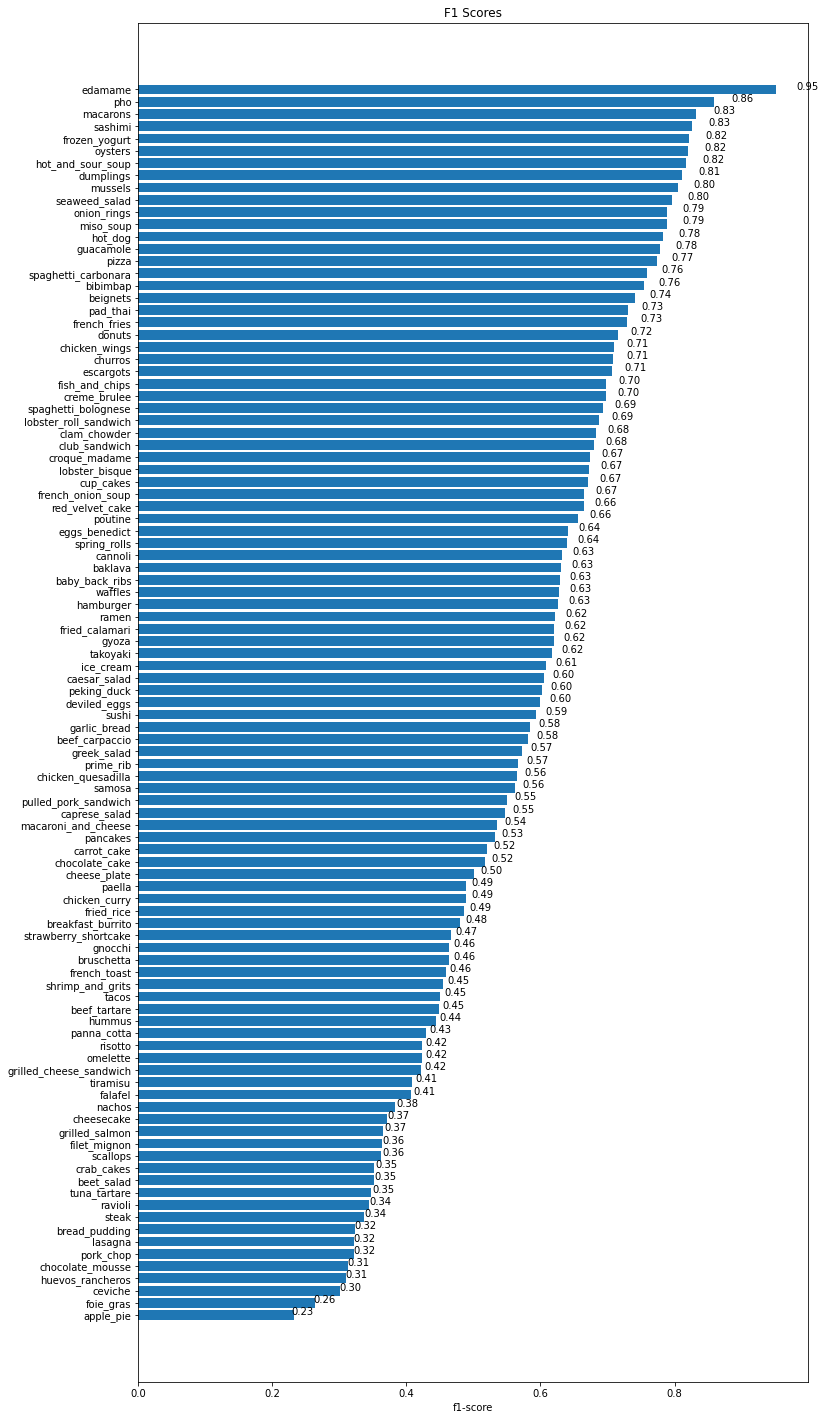

In [93]:
# Plot f1-scores
fig, ax = plt.subplots(figsize=(12, 25))

scores = ax.barh(range(len(f1_scores_df)), f1_scores_df['f1-score'].values)
ax.set_yticks(range(len(f1_scores_df)))
ax.set_yticklabels(list(f1_scores_df['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('F1 Scores')

# Reverse order
ax.invert_yaxis()

# Modified version of: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(
        1.05 * width, rect.get_y() + rect.get_height() / 1.5,
        f'{width:.2f}',
        ha='center', va='bottom'
    )

autolabel(scores)

Model seems to be performing really well on `edamame` and `pho`, but seems to be struggling in `foie_gras` and `apple_pie`.

Might have to get more images for these classes, or they're hard to be predicted fullstop.

### Visualize Predictions

Preprocess images:
* Read in a target image filepath
* Turn the image into a Tensor
* Resize the image to be the same size as the images the model has been trained on
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [96]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor, PNG files have 4 channels which could break if not specified
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img / 255.

  return img

In [97]:
class_names = test_data.class_names

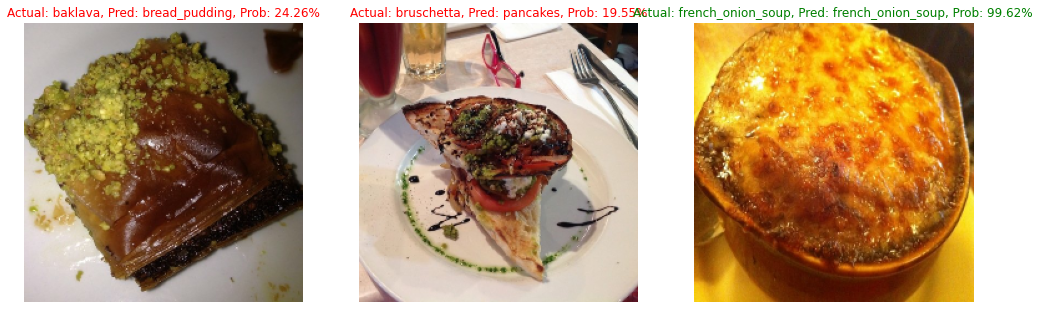

In [117]:
# Make predictions on random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(f'{test_dir}/{class_name}'))
  filepath = f'{test_dir}{class_name}/{filename}'

  # Create prediction
  img = load_and_prep_image(filepath, scale=False)
  # For predictions images usually must be expanded
  pred_prob = tf.nn.softmax(model.predict(tf.expand_dims(img, axis=0)))
  pred_class = class_names[int(tf.argmax(pred_prob, axis=1))]

  # Plot images
  plt.subplot(1, 3, i + 1)
  plt.imshow(img / 255.)

  # Style title
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f'Actual: {class_name}, Pred: {pred_class}, Prob: {tf.math.reduce_max(pred_prob) * 100:.2f}%', c=title_color)
  plt.axis(False)

### Findin most wrong predictions

The model at times predicts on some images with a very high prediction probability, but still getting the label wrong.

These most wrong predictions can help to give further insight into the model's performance.

Can reveal insights such as:
* Data issues (wrong labels - Model is right, label is wrong)
* Confusing classes (get better/more diverse data)

In [118]:
# Get the filenames of all of the test data
filepaths = []
for filepath in test_data.list_files(
    '101_food_classes_10_percent/test/*/*.jpg', 
    shuffle=False
):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [136]:
tf.math.reduce_max(pred_probs[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.009954207>

In [140]:
wrong_pred_df = pd.DataFrame({
    'img_path': filepaths,
    'y_true': y_labels,
    'y_pred': pred_classes,
    'confidence': tf.math.reduce_max(pred_probs, axis=1),
    'y_true_classname': [class_names[i] for i in y_labels],
    'y_pred_classname': [class_names[i] for i in pred_classes]
})

wrong_pred_df

,img_path,y_true,y_pred,confidence,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009954,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.010052,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009947,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.009919,apple_pie,bread_pudding
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009927,apple_pie,apple_pie
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.010056,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,100,0.010027,waffles,waffles
25247,b'101_food_classes_10_percent/test/waffles/961...,100,56,0.009945,waffles,huevos_rancheros
25248,b'101_food_classes_10_percent/test/waffles/970...,100,100,0.009940,waffles,waffles


In [141]:
# Is the prediction correct?
wrong_pred_df['pred_correct'] = wrong_pred_df['y_true'] == wrong_pred_df['y_pred']
wrong_pred_df.head()

,img_path,y_true,y_pred,confidence,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009954,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.010052,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009947,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.009919,apple_pie,bread_pudding,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.009927,apple_pie,apple_pie,True


In [142]:
# Get the top 100 most wrong predictions
top_100_wrong = wrong_pred_df[wrong_pred_df['pred_correct'] == False].sort_values('confidence', ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,confidence,y_true_classname,y_pred_classname,pred_correct
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.010066,strawberry_shortcake,red_velvet_cake,False
22203,b'101_food_classes_10_percent/test/seaweed_sal...,88,51,0.010066,seaweed_salad,guacamole,False
22684,b'101_food_classes_10_percent/test/spaghetti_b...,90,91,0.010065,spaghetti_bolognese,spaghetti_carbonara,False
19521,b'101_food_classes_10_percent/test/poutine/132...,78,40,0.010065,poutine,french_fries,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.010065,pancakes,omelette,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.010065,macarons,cup_cakes,False
11041,b'101_food_classes_10_percent/test/fried_rice/...,44,51,0.010065,fried_rice,guacamole,False
21216,b'101_food_classes_10_percent/test/risotto/493...,84,70,0.010065,risotto,pad_thai,False
11097,b'101_food_classes_10_percent/test/fried_rice/...,44,70,0.010065,fried_rice,pad_thai,False
5849,b'101_food_classes_10_percent/test/churros/254...,23,68,0.010065,churros,onion_rings,False


In [146]:
images_count = 12
start_idx = 0

for i, row in enumerate(top_100_wrong[start_idx:start_idx + images_count].itertuples()):
  print(row)


Pandas(Index=23631, img_path=b'101_food_classes_10_percent/test/strawberry_shortcake/2926631.jpg', y_true=94, y_pred=83, confidence=0.010066211223602295, y_true_classname='strawberry_shortcake', y_pred_classname='red_velvet_cake', pred_correct=False)
Pandas(Index=22203, img_path=b'101_food_classes_10_percent/test/seaweed_salad/441102.jpg', y_true=88, y_pred=51, confidence=0.010066032409667969, y_true_classname='seaweed_salad', y_pred_classname='guacamole', pred_correct=False)
Pandas(Index=22684, img_path=b'101_food_classes_10_percent/test/spaghetti_bolognese/3551987.jpg', y_true=90, y_pred=91, confidence=0.01006544940173626, y_true_classname='spaghetti_bolognese', y_pred_classname='spaghetti_carbonara', pred_correct=False)
Pandas(Index=19521, img_path=b'101_food_classes_10_percent/test/poutine/1320461.jpg', y_true=78, y_pred=40, confidence=0.010065418668091297, y_true_classname='poutine', y_pred_classname='french_fries', pred_correct=False)
Pandas(Index=18001, img_path=b'101_food_class

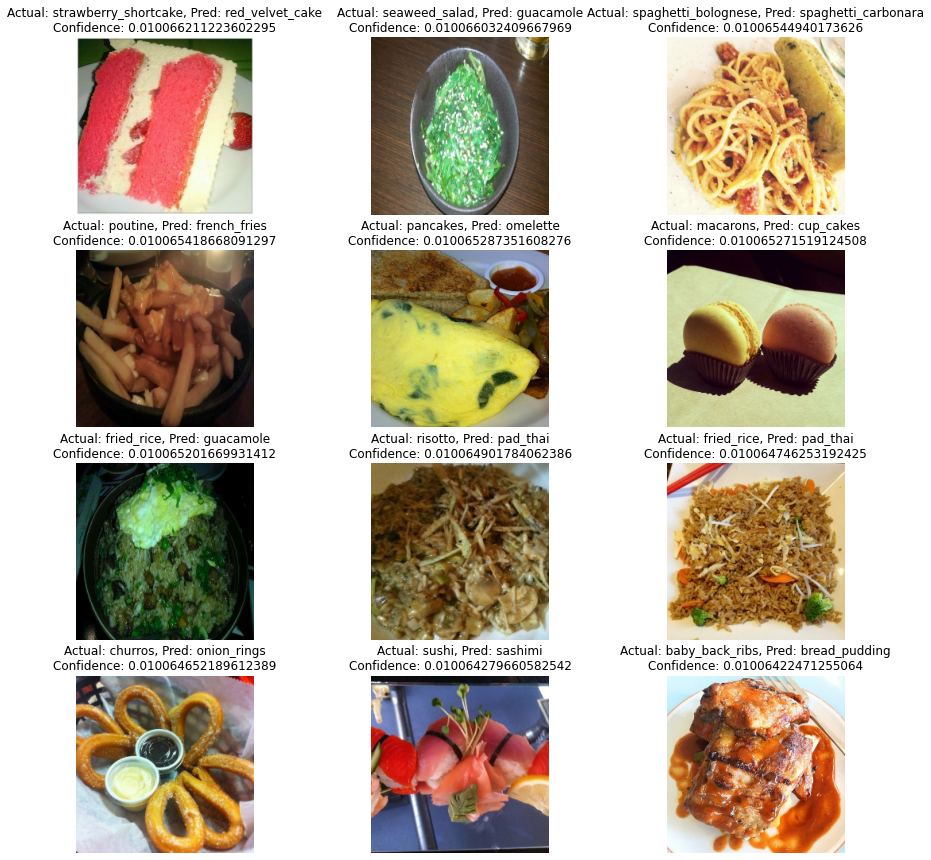

In [151]:
# Visualize random wrong images
plt.figure(figsize=(15, 15))

for i, row in enumerate(top_100_wrong[start_idx:start_idx + images_count].itertuples()):
  plt.subplot(4, 3, i + 1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, confidence, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img / 255.)
  plt.title(f'Actual: {y_true_classname}, Pred: {y_pred_classname}\nConfidence: {confidence}')
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

* Some of the labels might be wrong
 * If the model ends up being good enough, it may actually learn to predict very well on certain classes.
 * This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, often, the model can be used to help improve the labels in the dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as active learning.

* Could more samples be collected?
 * If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.